In [103]:
import matplotlib.pyplot as plt
import os
import numpy as np

np.set_printoptions(suppress=True, precision=10)


In [104]:
def load_poses(pose_path):
    """파일로부터 T_w_cam0 pose (n,4,4)를 불러옵니다."""
    poses = []
    try:
        with open(pose_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                T_w_cam0 = np.fromstring(line, dtype=float, sep=" ")
                T_w_cam0 = T_w_cam0.reshape(3, 4)
                T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))
                poses.append(T_w_cam0)
    except FileNotFoundError:
        print("Ground truth poses are not available.")
    return np.array(poses)


def load_calib(calib_path):
    """파일로부터 T_cam_velo (4,4) calibration을 불러옵니다."""
    T_cam_velo = []
    try:
        with open(calib_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                if "Tr:" in line:
                    line = line.replace("Tr:", "")
                    T_cam_velo = np.fromstring(line, dtype=float, sep=" ")
                    T_cam_velo = T_cam_velo.reshape(3, 4)
                    T_cam_velo = np.vstack((T_cam_velo, [0, 0, 0, 1]))
    except FileNotFoundError:
        print("Calibrations are not available.")
    return np.array(T_cam_velo)


def load_files(folder):
    """폴더 내의 모든 파일 (예: *.bin)을 정렬하여 불러옵니다."""
    file_paths = [
        os.path.join(dp, f)
        for dp, dn, fn in os.walk(os.path.expanduser(folder))
        for f in fn
    ]
    file_paths.sort()
    return file_paths


In [105]:
class BevScan:
    moving_learning_map = {
        0: 0,
        1: 0,
        9: 1,
        10: 1,
        11: 1,
        13: 1,
        15: 1,
        16: 1,
        18: 1,
        20: 1,
        30: 1,
        31: 1,
        32: 1,
        40: 1,
        44: 1,
        48: 1,
        49: 1,
        50: 1,
        51: 1,
        52: 1,
        60: 1,
        70: 1,
        71: 1,
        72: 1,
        80: 1,
        81: 1,
        99: 1,
        251: 2,
        252: 2,
        253: 2,
        254: 2,
        255: 2,
        256: 2,
        257: 2,
        258: 2,
        259: 2,
    }
    movable_learning_map = {
        0: 0,
        1: 0,
        9: 1,
        16: 1,
        40: 1,
        44: 1,
        48: 1,
        49: 1,
        50: 1,
        51: 1,
        52: 1,
        60: 1,
        70: 1,
        71: 1,
        72: 1,
        80: 1,
        81: 1,
        99: 1,
        10: 2,
        11: 2,
        13: 2,
        15: 2,
        18: 2,
        20: 2,
        30: 2,
        31: 2,
        32: 2,
        251: 2,
        252: 2,
        253: 2,
        254: 2,
        255: 2,
        256: 2,
        257: 2,
        258: 2,
        259: 2,
    }

    def __init__(self, velodyne_path, label_path, proj_H, proj_W, max_range, min_range):
        self.velodyne_path = velodyne_path
        self.label_path = label_path
        self.proj_H = proj_H
        self.proj_W = proj_W
        self.max_range = max_range
        self.min_range = min_range
        self.process()
    
    def load_velodyne(self):
        scan = np.fromfile(self.velodyne_path, dtype=np.float32).reshape((-1, 4)) # nx4
        points = scan[:, :3] # nx3
        remissions = scan[:, 3] # nx1
        homo_points = np.ones((points.shape[0], 4), dtype=np.float32) # nx4
        homo_points[:, :3] = points # nx4 (XYZ1, XYZ1, XYZ1, ... , XYZ1)

        self.homo_points = homo_points
        self.remissions = remissions
        return self.homo_points, self.remissions
    
    def load_label(self):
        """
        .label 파일에서 semantic 라벨과 instance 라벨을 읽어옴.
        반환: sem_label (n,), inst_label (n,)
        """
        label = np.fromfile(self.label_path, dtype=np.int32)
        self.sem_label = label & 0xFFFF
        self.inst_label = label >> 16
        return self.sem_label, self.inst_label

    def create_ternary_label(self, mapping_dict):
        mapped = np.full_like(self.bev_sem_label, -1, dtype=np.int32)
        unique = np.unique(self.bev_sem_label)
        for val in unique:
            if val in mapping_dict:
                mapped[self.bev_sem_label == val] = mapping_dict[val]
            else:
                mapped[self.bev_sem_label == val] = 0
        ternary = np.where(self.bev_sem_label == -1, 0, mapped)
        return ternary
    
    @staticmethod
    def bev_projection_only(homo_points, proj_H, proj_W, max_range, min_range):
        xy_dist = np.sqrt(homo_points[:, 0] ** 2 + homo_points[:, 1] ** 2)
        valid_mask = (xy_dist > min_range) & (xy_dist < max_range)
        filtered_points = homo_points[valid_mask]
        filtered_dist = xy_dist[valid_mask]

        x_img = (filtered_points[:, 0] + max_range) / (2.0 * max_range)
        y_img = (filtered_points[:, 1] + max_range) / (2.0 * max_range)
        x_img = np.clip(np.floor(x_img * proj_W), 0, proj_W - 1).astype(np.int32)
        y_img = np.clip(np.floor(y_img * proj_H), 0, proj_H - 1).astype(np.int32)

        # 먼 점부터 투영 (덮어쓰기를 위해)
        order = np.argsort(filtered_dist)[::-1]
        x_img = x_img[order]
        y_img = y_img[order]
        filtered_dist = filtered_dist[order]

        bev_range = np.full((proj_H, proj_W), 0, dtype=np.float32)
        bev_range[y_img, x_img] = 1

        norm_range = np.clip(bev_range, 0, max_range) / max_range

        return bev_range

    def bev_projection_full(self):
        xy_dist = np.sqrt(self.homo_points[:, 0] ** 2 + self.homo_points[:, 1] ** 2)
        valid_mask = (xy_dist > self.min_range) & (xy_dist < self.max_range)
        filtered_points = self.homo_points[valid_mask]
        filtered_rem = self.remissions[valid_mask]
        filtered_dist = xy_dist[valid_mask]
        orig_idx = np.nonzero(valid_mask)[0]  # 원본 점 인덱스

        if filtered_points.shape[0] == 0:
            empty = np.full((self.proj_H, self.proj_W), -1, dtype=np.float32)
            return (
                empty,
                np.full((self.proj_H, self.proj_W, 3), -1, dtype=np.float32),
                empty,
                np.array([]),
                np.array([]),
                np.array([]),
                np.full((self.proj_H, self.proj_W), -1, dtype=np.int32),
            )

        # x, y 좌표를 [0,1]로 정규화 후 이미지 크기에 맞게 변환
        x_img = (filtered_points[:, 0] + self.max_range) / (2.0 * self.max_range)
        y_img = (filtered_points[:, 1] + self.max_range) / (2.0 * self.max_range)
        x_img = np.clip(np.floor(x_img * self.proj_W), 0, self.proj_W - 1).astype(np.int32)
        y_img = np.clip(np.floor(y_img * self.proj_H), 0, self.proj_H - 1).astype(np.int32)

        # 먼 점부터 투영 (덮어쓰기를 위해)
        order = np.argsort(filtered_dist)[::-1]
        x_img = x_img[order]
        y_img = y_img[order]
        filtered_dist = filtered_dist[order]
        filtered_points = filtered_points[order]
        filtered_rem = filtered_rem[order]
        proj_idx_ordered = orig_idx[order]

        bev_range = np.full((self.proj_H, self.proj_W), 0, dtype=np.float32)
        bev_xyz = np.full((self.proj_H, self.proj_W, 3), -1, dtype=np.float32)
        bev_remission = np.full((self.proj_H, self.proj_W), -1, dtype=np.float32)
        proj_idx = np.full((self.proj_H, self.proj_W), -1, dtype=np.int32)

        bev_range[y_img, x_img] = 1
        bev_xyz[y_img, x_img, :] = filtered_points[:, :3]
        bev_remission[y_img, x_img] = filtered_rem
        proj_idx[y_img, x_img] = proj_idx_ordered


        # 정규화: range와 remission 채널
        norm_range = np.clip(bev_range, 0, self.max_range) / self.max_range
        if np.any(bev_remission > 0):
            norm_rem = np.clip(
                bev_remission, 0, np.max(bev_remission[bev_remission > 0])
            ) / np.max(bev_remission[bev_remission > 0])
        else:
            norm_rem = bev_remission

        unproj_n_points = x_img.shape[0]
        tmp_x = np.full(150000, -1, dtype=np.longlong)
        tmp_x[:unproj_n_points] = x_img
        tmp_y = np.full(150000, -1, dtype=np.longlong)
        tmp_y[:unproj_n_points] = y_img
        tmp_unproj_range = np.full(150000, -1.0, dtype=np.float32)
        tmp_unproj_range[:unproj_n_points] = filtered_dist
            
        self.bev_range = bev_range
        self.bev_xyz = bev_xyz.transpose((2, 0, 1))  # HWC -> CHW
        self.bev_remission = norm_rem
        self.bev_proj_x = tmp_x
        self.bev_proj_y = tmp_y
        self.bev_unproj_range = tmp_unproj_range
        self.bev_proj_idx = proj_idx
    
        return self.bev_range, self.bev_xyz, self.bev_remission, self.bev_proj_x, self.bev_proj_y, self.bev_unproj_range, self.bev_proj_idx
    
    def bev_labels_full(self):
        self.bev_sem_label = np.full((self.proj_H, self.proj_W), -1, dtype=np.int32)
        valid = self.bev_proj_idx >= 0
        self.bev_sem_label[valid] = self.sem_label[self.bev_proj_idx[valid]]

        self.bev_moving_ternary_label = self.create_ternary_label(BevScan.moving_learning_map)
        self.bev_movable_ternary_label = self.create_ternary_label(BevScan.movable_learning_map)

        return self.bev_sem_label, self.bev_moving_ternary_label, self.bev_movable_ternary_label

    def process(self):
        self.load_velodyne()
        self.load_label()
        self.bev_projection_full()
        self.bev_labels_full()

In [106]:
seq_id = "09"
frame_idx = 700

scans_folder = f"/home/ssd_4tb/minjae/KITTI/dataset/sequences/{seq_id}/velodyne"
labels_folder = f"/home/ssd_4tb/minjae/KITTI/dataset/sequences/{seq_id}/labels"
pose_file = f"/home/ssd_4tb/minjae/KITTI/dataset/sequences/{seq_id}/poses.txt"
calib_file = f"/home/ssd_4tb/minjae/KITTI/dataset/sequences/{seq_id}/calib.txt"

In [107]:
# Pose 관련
poses = np.array(load_poses(pose_file))
inv_frame0 = np.linalg.inv(poses[0])
T_cam_velo = load_calib(calib_file) 
T_cam_velo = np.asarray(T_cam_velo).reshape((4, 4))
T_velo_cam = np.linalg.inv(T_cam_velo)
new_poses = []
for pose in poses:
    new_poses.append(T_velo_cam.dot(inv_frame0).dot(pose).dot(T_cam_velo))
poses = np.array(new_poses)

# Scan/Label 관련
scan_paths = load_files(scans_folder)
labels_paths = load_files(labels_folder)

In [113]:
residual_images = []
last_images = []

bev_h, bev_w, M_range, m_range = 384, 384, 50, 2

current_pose = poses[frame_idx]
current_bev_package = BevScan(scan_paths[frame_idx], labels_paths[frame_idx], bev_h, bev_w, M_range, m_range)
current_bev = current_bev_package.bev_range


for num_last_n in range(1, 9):
    last_pose = poses[frame_idx - num_last_n]
    last_bev_package = BevScan(scan_paths[frame_idx - num_last_n], labels_paths[frame_idx - num_last_n], bev_h, bev_w, M_range, m_range)
    last_scan_transformed = (np.linalg.inv(current_pose) @ last_pose @ last_bev_package.homo_points.T).T[:, :3]
    last_bev = BevScan.bev_projection_only(last_scan_transformed.astype(np.float32), bev_h, bev_w, M_range, m_range)

    diff_image = np.abs(current_bev - last_bev)

    residual_images.append(diff_image)
    last_images.append(last_bev)

[0. 1.]
[0 1]
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[0. 1.]
값 0.0의 개수: 139065
값 1.0의 개수: 8391


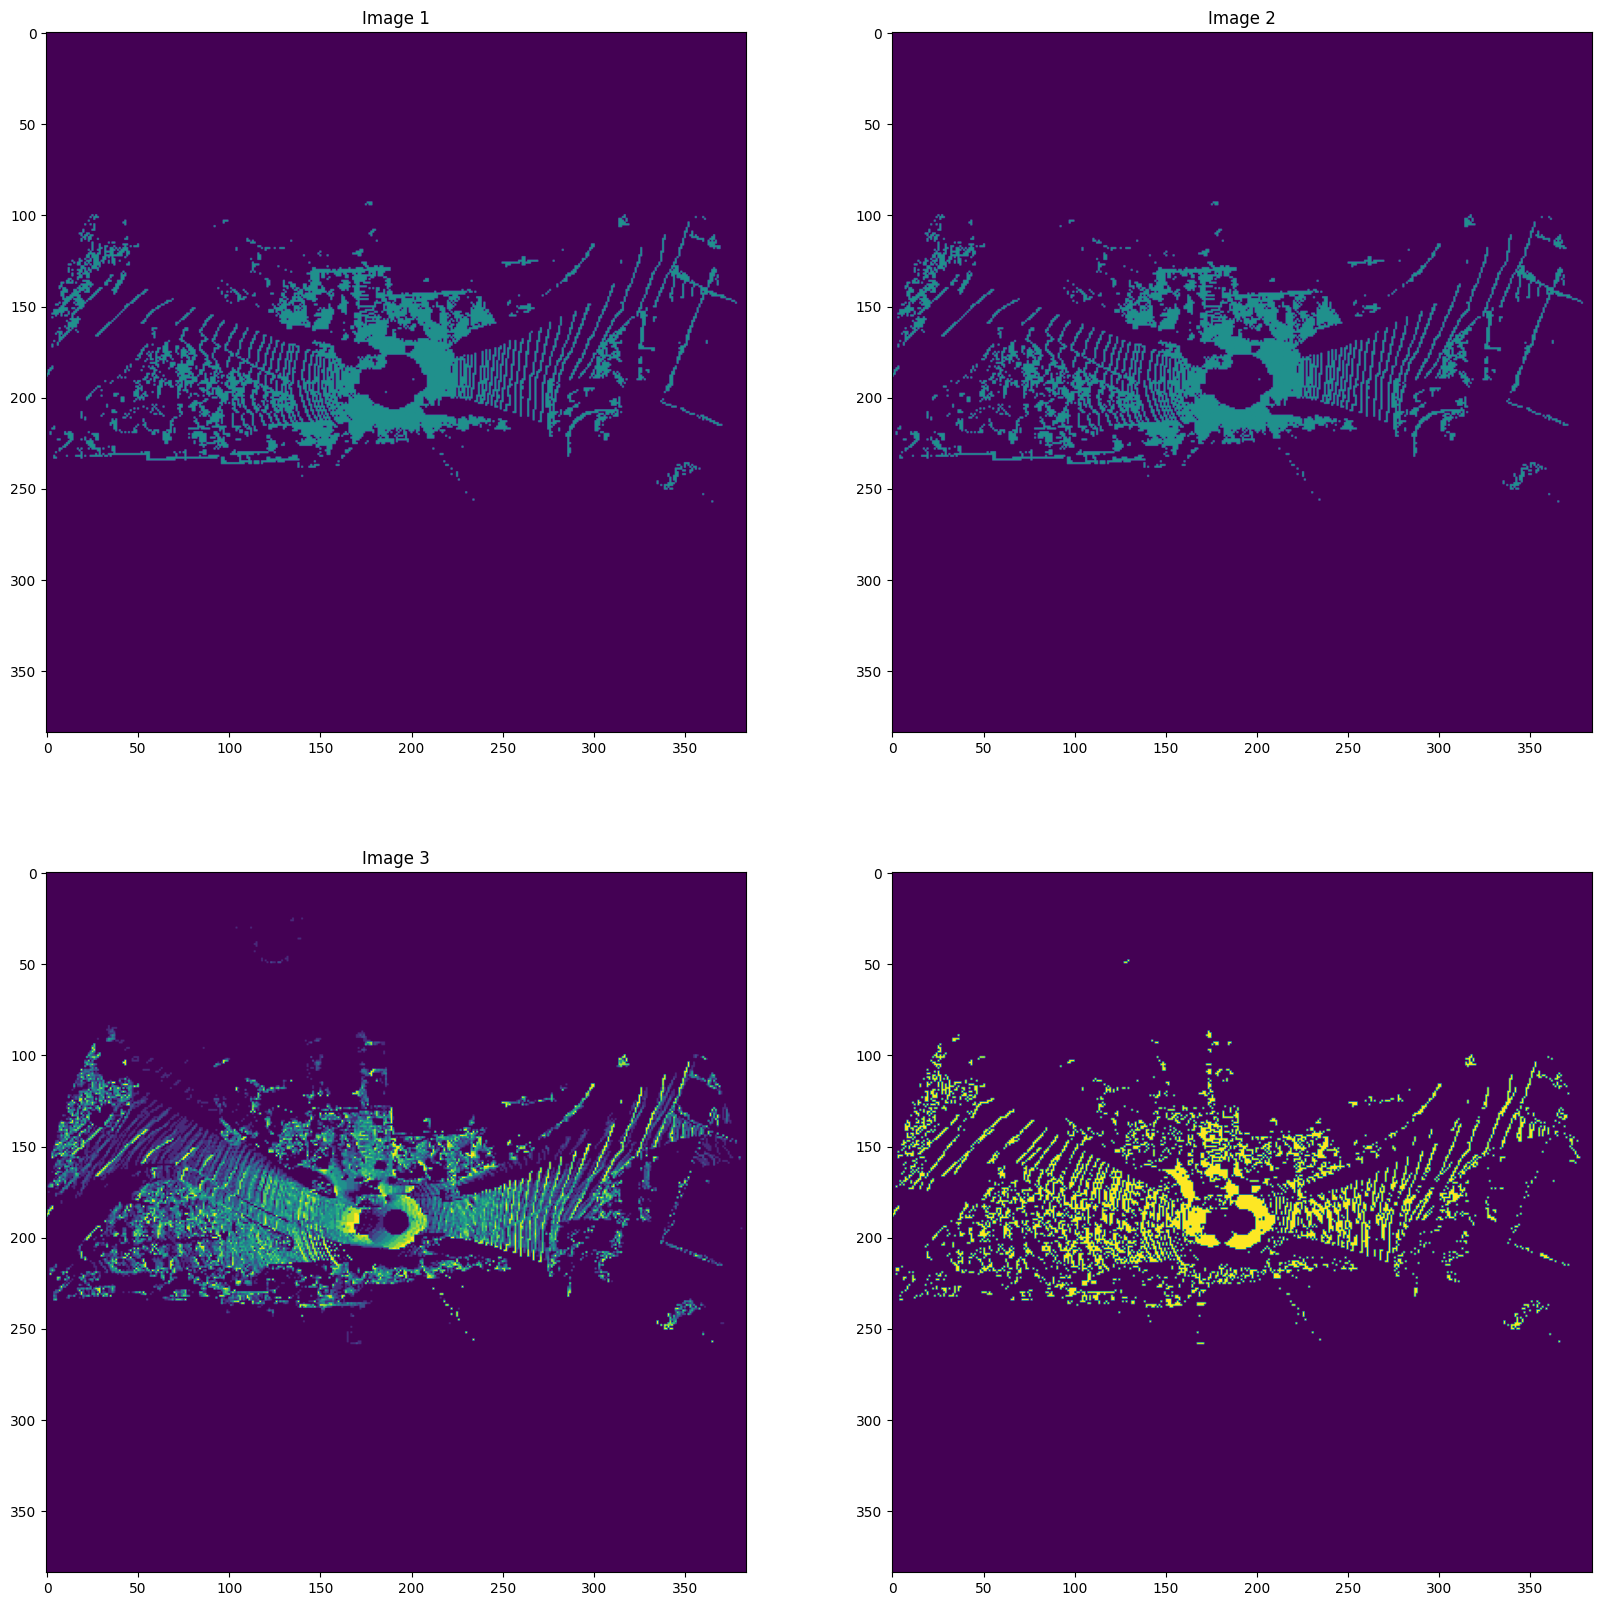

In [114]:
image1 = current_bev
image2 = current_bev_package.bev_moving_ternary_label
image3 = np.mean(residual_images, axis=0)
image4 = residual_images[4]

print(np.unique(image1), np.unique(image2), np.unique(image3), np.unique(image4), sep="\n", end="\n")
unique_values, counts = np.unique(image4, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"값 {value}의 개수: {count}")

# Figure 생성
plt.figure(figsize=(20, 20))  # 가로 10인치, 세로 5인치 크기 설정

# 첫 번째 이미지
plt.subplot(2, 2, 1) 
plt.imshow(image1, vmin=0, vmax=2)
plt.title("Image 1")

# 두 번째 이미지
plt.subplot(2, 2, 2) 
plt.imshow(image2, vmin=0, vmax=2)
plt.title("Image 2")

# 세 번째 이미지
plt.subplot(2, 2, 3) 
plt.imshow(image3)
plt.title("Image 3")

plt.subplot(2, 2, 4) 
plt.imshow(image4, vmin=0, vmax=1)

# 출력
plt.show()

In [110]:
!ls

LICENSE      aaa.ipynb	infer.py  script	   train_yaml
__init__.py  common	log	  train.py	   utils
__pycache__  config	modules   train_2stage.py
